In [2]:
!pip install gensim

In [3]:
!pip install spacy

In [4]:
!pip install seaborn
!pip install keras

In [5]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


In [6]:
train = pd.read_csv('C:/Users/ramya/OneDrive/Desktop/Projects/train.csv')

In [7]:
train.head(15)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [8]:
#Let's get the dataset lenght
len(train)

27481

In [9]:
#Is there any other different value than neutral, negative and positive?
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [10]:
#How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


## Data Cleaning

In [11]:
#Let's keep only the columns that we're going to use
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [12]:
#Is there any null value?
train["selected_text"].isnull().sum()

1

In [13]:
#Let's fill the only null value.
train["selected_text"].fillna("No content", inplace = True)

In [14]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [15]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [17]:
len(data_words)

27481

In [18]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [19]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [20]:
data = np.array(data)

## Label Encoding

In [21]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [22]:
len(labels)

27481

## Data sequencing and splitting

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [24]:
print(labels)


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [25]:
#Splittting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


# **SINGLE LSTM LAYER MODEL**

In [26]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/70
645/645 [==============================] - ETA: 0s - loss: 0.8192 - accuracy: 0.6428
Epoch 1: val_accuracy improved from -inf to 0.70878, saving model to best_model1.hdf5
645/645 [==============================] - 71s 107ms/step - loss: 0.8192 - accuracy: 0.6428 - val_loss: 0.6719 - val_accuracy: 0.7088
Epoch 2/70
645/645 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.7658
Epoch 2: val_accuracy improved from 0.70878 to 0.78940, saving model to best_model1.hdf5
645/645 [==============================] - 56s 87ms/step - loss: 0.5850 - accuracy: 0.7658 - val_loss: 0.5337 - val_accuracy: 0.7894
Epoch 3/70
645/645 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.8016
Epoch 3: val_accuracy improved from 0.78940 to 0.80105, saving model to best_model1.hdf5
645/645 [==============================] - 57s 89ms/step - loss: 0.5095 - accuracy: 0.8016 - val_loss: 0.5208 - val_accuracy: 0.8010
Epoch 4/70
645/645 [============================

645/645 [==============================] - 56s 87ms/step - loss: 0.3382 - accuracy: 0.8733 - val_loss: 0.4332 - val_accuracy: 0.8379
Epoch 28/70
644/645 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8764
Epoch 28: val_accuracy improved from 0.83787 to 0.83918, saving model to best_model1.hdf5
645/645 [==============================] - 46s 71ms/step - loss: 0.3368 - accuracy: 0.8764 - val_loss: 0.4327 - val_accuracy: 0.8392
Epoch 29/70
645/645 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.8756
Epoch 29: val_accuracy did not improve from 0.83918
645/645 [==============================] - 50s 77ms/step - loss: 0.3388 - accuracy: 0.8756 - val_loss: 0.4318 - val_accuracy: 0.8386
Epoch 30/70
645/645 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8777
Epoch 30: val_accuracy did not improve from 0.83918
645/645 [==============================] - 62s 97ms/step - loss: 0.3348 - accuracy: 0.8777 - val_loss: 0.4364 - val_

645/645 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.8892
Epoch 56: val_accuracy did not improve from 0.84296
645/645 [==============================] - 52s 81ms/step - loss: 0.3016 - accuracy: 0.8892 - val_loss: 0.4403 - val_accuracy: 0.8373
Epoch 57/70
644/645 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8905
Epoch 57: val_accuracy did not improve from 0.84296
645/645 [==============================] - 50s 78ms/step - loss: 0.3006 - accuracy: 0.8905 - val_loss: 0.4378 - val_accuracy: 0.8395
Epoch 58/70
644/645 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8895
Epoch 58: val_accuracy did not improve from 0.84296
645/645 [==============================] - 51s 79ms/step - loss: 0.2996 - accuracy: 0.8894 - val_loss: 0.4437 - val_accuracy: 0.8377
Epoch 59/70
645/645 [==============================] - ETA: 0s - loss: 0.2975 - accuracy: 0.8931
Epoch 59: val_accuracy did not improve from 0.84296
645/645 [========

In [27]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/70
645/645 [==============================] - ETA: 0s - loss: 0.7923 - accuracy: 0.6524
Epoch 1: val_accuracy improved from -inf to 0.76568, saving model to best_model2.hdf5
645/645 [==============================] - 173s 254ms/step - loss: 0.7923 - accuracy: 0.6524 - val_loss: 0.6140 - val_accuracy: 0.7657
Epoch 2/70
645/645 [==============================] - ETA: 0s - loss: 0.5606 - accuracy: 0.7754
Epoch 2: val_accuracy did not improve from 0.76568
645/645 [==============================] - 165s 255ms/step - loss: 0.5606 - accuracy: 0.7754 - val_loss: 0.5583 - val_accuracy: 0.7635
Epoch 3/70
645/645 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.8081
Epoch 3: val_accuracy improved from 0.76568 to 0.80629, saving model to best_model2.hdf5
645/645 [==============================] - 220s 341ms/step - loss: 0.4956 - accuracy: 0.8081 - val_loss: 0.4891 - val_accuracy: 0.8063
Epoch 4/70
645/645 [==============================] - ETA: 0s - loss: 0.4657 - ac

645/645 [==============================] - 180s 280ms/step - loss: 0.3270 - accuracy: 0.8787 - val_loss: 0.4237 - val_accuracy: 0.8396
Epoch 28/70
645/645 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.8787
Epoch 28: val_accuracy did not improve from 0.84078
645/645 [==============================] - 220s 341ms/step - loss: 0.3264 - accuracy: 0.8787 - val_loss: 0.4225 - val_accuracy: 0.8398
Epoch 29/70
645/645 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.8826
Epoch 29: val_accuracy did not improve from 0.84078
645/645 [==============================] - 155s 240ms/step - loss: 0.3239 - accuracy: 0.8826 - val_loss: 0.4245 - val_accuracy: 0.8393
Epoch 30/70
645/645 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.8819
Epoch 30: val_accuracy did not improve from 0.84078
645/645 [==============================] - 149s 230ms/step - loss: 0.3209 - accuracy: 0.8819 - val_loss: 0.4251 - val_accuracy: 0.8398
Epoch 31/70
6

645/645 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.8969
Epoch 56: val_accuracy improved from 0.84209 to 0.84398, saving model to best_model2.hdf5
645/645 [==============================] - 83s 129ms/step - loss: 0.2836 - accuracy: 0.8969 - val_loss: 0.4392 - val_accuracy: 0.8440
Epoch 57/70
645/645 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.8983
Epoch 57: val_accuracy did not improve from 0.84398
645/645 [==============================] - 84s 130ms/step - loss: 0.2815 - accuracy: 0.8983 - val_loss: 0.4456 - val_accuracy: 0.8415
Epoch 58/70
645/645 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.9014
Epoch 58: val_accuracy did not improve from 0.84398
645/645 [==============================] - 83s 129ms/step - loss: 0.2756 - accuracy: 0.9014 - val_loss: 0.4561 - val_accuracy: 0.8430
Epoch 59/70
645/645 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.9003
Epoch 59: val_accuracy did n

In [28]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model2.hdf5")

In [29]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 7s - loss: 0.4567 - accuracy: 0.8446 - 7s/epoch - 31ms/step
Model accuracy:  0.8445640802383423


In [30]:
predictions = best_model.predict(X_test)

215/215 [==============================] - 7s 27ms/step


In [31]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

<AxesSubplot: >

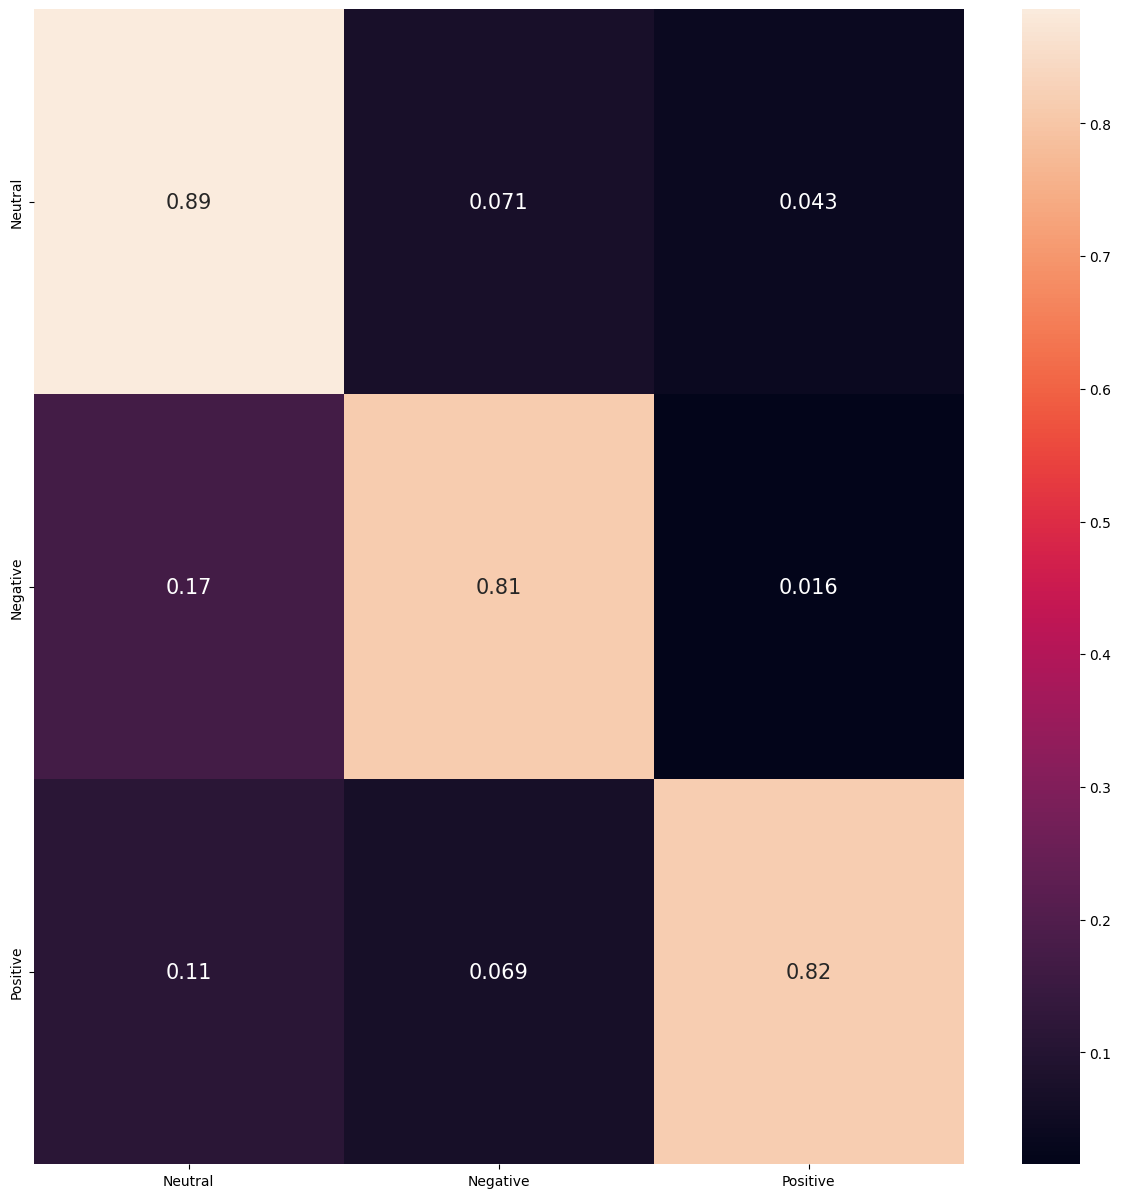

In [32]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [33]:
sentiment = ['Neutral','Negative','Positive']

In [34]:
sequence = tokenizer.texts_to_sequences(['The boy was slow'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 47ms/step


'Negative'

In [35]:
sequence = tokenizer.texts_to_sequences(['she is excited'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 52ms/step


'Positive'

In [36]:
import pyttsx3

In [37]:
# Initialize the pyttsx3 engine
engine = pyttsx3.init()

# Set the voice to use
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[1].id) # use a female voice

In [43]:
def speak_with_emotion(text):
    lines = text.split(".")
    for line in lines:
    # Analyze the sentiment of the text
        sequence = tokenizer.texts_to_sequences([line])
        test = pad_sequences(sequence, maxlen=max_len)
        s=sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

        # Modify the speech parameters based on the sentiment
        if s=='Positive':
            # Positive sentiment
            engine.setProperty('rate', 175) # increase the speed
            engine.setProperty('pitch', 215) # increase the pitch
        elif s=='Negative':
            # Negative sentiment
            engine.setProperty('rate', 100) # decrease the speed
            engine.setProperty('pitch', 20) # lower the pitch
        else:
            # Neutral sentiment
            engine.setProperty('rate', 125) # default settings
            engine.setProperty('pitch', 100)

        # Speak the text
        engine.say(line)
        engine.runAndWait()

In [46]:
text="The boy is happy . She is crying . I am angry"
speak_with_emotion(text)

1/1 [==============================] - 0s 16ms/step


In [41]:
#Saving weights and tokenizer so we can reduce training time on SageMaker

# serialize model to JSON
model_json = best_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
best_model.save_weights("model-weights.h5")
print("Model saved")

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Tokenizer saved')

Model saved
Tokenizer saved
